In [1]:
import os
import sys
sys.path.insert(0, r'..\..')
import paths

import panel as pn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import functions_bondjango as bd
import functions_kinematic as fk
import functions_plotting as fp
import functions_preprocessing as fpr
import functions_misc as fm
import functions_data_handling as fd
import pandas as pd
import numpy as np
import h5py

from scipy.stats import sem
from datetime import datetime
line_width = 5

In [2]:
def load_h5_df(df_path):
    h5_obj = pd.HDFStore(df_path)

    data_dict = {}
    data_dict['traces'] = h5_obj.get("full_traces")
    data_dict['session_params'] = h5_obj.get("params")

    # Add a column to the trial_params data set that will properly index the trials
    trial_params = h5_obj.get("trial_set")
    trial_params['trial_num'] = trial_params.index + 1
    data_dict['trial_params'] = trial_params

    return data_dict

In [3]:
def load_VScreens_datasets(search_string, exclusion=None):

    valid_experiments = []

    data_all = bd.query_database('analyzed_data', search_string)

    for ds in data_all:
        if exclusion is not None:
            if exclusion not in ds['analysis_path']:
                exp = load_h5_df(ds['analysis_path'])
                exp['date'] = datetime.strptime(ds['date'], '%Y-%m-%dT%H:%M:%SZ') 
                valid_experiments.append(exp)
                print(ds['analysis_path'])
            else:
                continue
        else:
            exp = load_h5_df(ds['analysis_path'])
            exp['date'] = datetime.strptime(ds['date'], '%Y-%m-%dT%H:%M:%SZ') 
            valid_experiments.append(exp)
            print(ds['analysis_path'])

    # load the data
    return valid_experiments

In [4]:
def recalculate_2D_target_mouse_distance(exp_traces):

    temp_target_x = exp_traces['target_x'].copy()
    temp_target_y = exp_traces['target_y'].copy()

    print('target y max:', max(temp_target_y), 'target y min:', min(temp_target_y[temp_target_y != -1]))

    mouse_x = exp_traces['mouse_x'].copy()
    mouse_y = exp_traces['mouse_y'].copy()
    print('mouse y max:', max(mouse_y), 'mouse y min:', min(mouse_y))

    x_diff = [abs(max(mouse_x) - max(temp_target_x)), 
             abs(min(mouse_x) - min(temp_target_x[temp_target_x != -1]))]
    y_diff = [abs(max(mouse_y) - max(temp_target_y)),
              abs(min(mouse_y) - min(temp_target_y[temp_target_y != -1]))]

    print('x offset:', x_diff, 'y offset:', y_diff)

    temp_target_y[(temp_target_y > 0)] -= y_diff[0]
    temp_target_y[(temp_target_y < 0) & (temp_target_y > -1)] += y_diff[1]
    
    print('recalc target y max:', max(temp_target_y), 'recalc target y min:', min(temp_target_y[temp_target_y != -1]), '\n')

    # replace the target y coordinates with the newly calculated ones
    exp_traces['target_y'] = temp_target_y

    mouse_coord = exp_traces.loc[:, ['mouse_x', 'mouse_y']].to_numpy()
    target_coord = exp_traces.loc[:, ['target_x', 'target_y']].to_numpy()
    target_mouse_distance = fk.distance_calculation(target_coord, mouse_coord)

    exp_traces['target_mouse_distance_recalc'] = target_mouse_distance
    exp_traces['target_mouse_x_distance'] = np.abs(temp_target_x - exp_traces['mouse_x'])
    exp_traces['target_mouse_y_distance'] = np.abs(temp_target_y - exp_traces['mouse_y']) 

    return exp_traces   

In [5]:
def recalculate_3D_target_mouse_distance(exp_traces):

    # temp_target_x = exp_traces['target_x'].copy()
    # temp_target_y = exp_traces['target_y'].copy()

    # # print('target y max:', max(temp_target_y), 'target y min:', min(temp_target_y[temp_target_y != -1]))

    # mouse_x = exp_traces['mouse_x'].copy()
    # mouse_y = exp_traces['mouse_y'].copy()
    # # print('mouse y max:', max(mouse_y), 'mouse y min:', min(mouse_y))

    # x_diff = [abs(max(mouse_x) - max(temp_target_x)), 
    #          abs(min(mouse_x) - min(temp_target_x[temp_target_x != -1]))]
    # y_diff = [abs(max(mouse_y) - max(temp_target_y)),
    #           abs(min(mouse_y) - min(temp_target_y[temp_target_y != -1]))]

    # print('x offset:', x_diff, 'y offset:', y_diff)

    # temp_target_y[(temp_target_y > 0)] -= y_diff[0]
    # temp_target_y[(temp_target_y < 0) & (temp_target_y > -1)] += y_diff[1]
    
    # print('recalc target y max:', max(temp_target_y), 'recalc target y min:', min(temp_target_y[temp_target_y != -1]), '\n')

    # # replace the target y coordinates with the newly calculated ones
    # exp_traces['target_y'] = temp_target_y

    mouse_coord = exp_traces.loc[:, ['mouse_x', 'mouse_y']].to_numpy()
    target_coord = exp_traces.loc[:, ['target_x', 'target_y']].to_numpy()
    target_mouse_distance = fk.distance_calculation(target_coord, mouse_coord)

    exp_traces['target_mouse_distance_recalc'] = target_mouse_distance
    # exp_traces['target_mouse_x_distance'] = np.abs(temp_target_x - exp_traces['mouse_x'])
    # exp_traces['target_mouse_y_distance'] = np.abs(temp_target_y - exp_traces['mouse_y']) 

    return exp_traces   

In [6]:
def get_parameter_traces(traces: pd.DataFrame, trials: np.ndarray) -> list:
    parameter_traces = pd.DataFrame()

    for trial in trials:
        trial_trace = traces.loc[traces['trial_num'] == trial].copy()
        parameter_traces = parameter_traces.append(trial_trace)

    grouped_parameter = parameter_traces.groupby(['trial_num']).agg(list)    

    return grouped_parameter


In [7]:
def thres_function(param, thres):
    return param <= thres

In [8]:
def encounter_finder(data_in, key, threshold=0.05, window=1.5, start_dist_cutoff=0.05, avg_speed_cutoff=0.15):
    all_encounters = []
    all_trials = []
    valid_encounters = []
    valid_trials = []
    
    for index, row in data_in.iterrows():

        trial = pd.DataFrame(row).T
        trial = trial.apply(pd.Series.explode)

        # This gets us all encounters within one trial
        trial_encs = fpr.timed_event_finder(trial, key, threshold, thres_function, window=window)

        is_enc = []
        good_enc = []
        trial_traces = []
        valid_traces = []

        if len(trial_encs) == 0:
            valid_encounters.append(good_enc)
            valid_trials.append(valid_traces)
            all_encounters.append(is_enc)
            all_trials.append(trial_traces)
        else:
            enc_id_group = trial_encs.groupby('event_id')
            for e, group in enc_id_group:
                trial_traces.append(trial.copy())
                is_enc.append(group.copy())
                # group.head()
                quarter_idx = len(group)//4
                mid_idx = len(group)//2
                # Qualifications for an encounter as in Procacci (decreasing target_mouse_angle, start >= 5cm away, speed >= 15cm/s)
                # angle_start = fk.circmean_deg(group['target_delta_heading'][:quarter_idx].to_list())
                angle_start = group['target_delta_heading'][quarter_idx]
                angle_enc = group['target_delta_heading'][mid_idx]
                angle_change = angle_enc - angle_start
                avg_speed = np.mean(group['mouse_speed'][:mid_idx])
                start_dist = np.abs(group[key][mid_idx] - group[key][0])

                if (start_dist >= start_dist_cutoff) and (avg_speed >= avg_speed_cutoff):#  and (angle_change <= 0):
                    # This is a good encounter
                    good_enc.append(group.copy())
                    valid_traces.append(trial)
                else:
                    # This does not meet one or more of the criteria, so we remove it.
                    pass
            
            valid_encounters.append(good_enc)
            valid_trials.append(valid_traces)
            all_encounters.append(is_enc)
            all_trials.append(trial_traces)

    return all_encounters, all_trials, valid_encounters, valid_trials

In [9]:
def calculate_bins(time_trace, bin_duration:int):
    # Bin in minutes
    return time_trace // (60 * bin_duration)

In [10]:
# define the name to be used for the saved figures
dimensionality = '2D'
save_name = 'VScreen_' + dimensionality

search_string = 'result:test, lighting:normal, rig:VScreen, analysis_type:preprocessing, ltdate:2021-03-22T00-00-00, notes:{}'.format(dimensionality)
data = load_VScreens_datasets(search_string, exclusion="removedtracker")

J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_15_40_54_VScreen_DG_200526_d_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_13_31_20_VScreen_DG_200526_c_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_11_55_22_VScreen_DG_200526_b_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_12_2020_10_29_00_VScreen_DG_200526_a_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_14_30_08_VScreen_DG_200526_d_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_13_02_29_VScreen_DG_200526_c_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_11_36_46_VScreen_DG_200526_b_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_11_2020_10_13_02_VScreen_DG_200526_a_test_2D_preproc.hdf5
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\11_10_2020_14_18_20_VScreen_DG_200526_d_test_2D_preproc.hdf5
J:\Drago G

In [11]:
exp_manipulation_params = ['color_target', 'scale', 'speed']
trial_encounters = pd.DataFrame(columns=['date', 'experiment', 'trial_num', 'bin', 'target_color', 'speed', 'scale', 'encounters'])

# encounter_criteria
dist_thresh = 0.05
speed_cutoff = 0.10
start_distance_cutoff = 0.05
window = 2

test_ds = data[3:5]

# For later visualization
all_valid_encs = []
all_encounters = []
bin_duration = 10    # minutes

# Test on example dataset
for exp_num, df in tqdm(enumerate(data), total=len(data)):
    
    # In the 2D case, the targets are outside the boundaries of the arena
    if dimensionality == '2D':
        df['traces'] = recalculate_2D_target_mouse_distance(df['traces'])
    else:
        df['traces'] = recalculate_3D_target_mouse_distance(df['traces'])
    
    df['traces']['date'] = df['date'].strftime("%Y-%m-%d")
    df['traces']['bin'] = calculate_bins(df['traces']['time_vector'], bin_duration)

    group_idxs_color_param = df['trial_params'].groupby(exp_manipulation_params)

    temp_storage_dict = dict.fromkeys(list(trial_encounters.columns))


    for key, item in group_idxs_color_param:

        trial_nums = item['trial_num'].to_list()
        parameter_traces = get_parameter_traces(df['traces'], trial_nums)

        # Use an updated encounter finder that encorporates Hoy et al. criteria to find interactions with target during each trial
        all_trial_encounters, encounter_trials, valid_encounters, valid_enc_trials = encounter_finder(parameter_traces,
                                        'target_mouse_distance_recalc', 
                                        threshold=dist_thresh, 
                                        avg_speed_cutoff=speed_cutoff, 
                                        start_dist_cutoff=start_distance_cutoff,
                                        window=window)
        
        for trial_encs, trials in zip(valid_encounters, valid_enc_trials):
            if len(trial_encs) != 0:
                for e, t in zip(trial_encs, trials):
                    all_valid_encs.append([e, t, (key[0], key[1][0] * 100, key[2]*100)])

        for trial_encs, trials in zip(all_trial_encounters, encounter_trials):
            if len(trial_encs) != 0:
                for e, t in zip(trial_encs, trials):
                    all_encounters.append([e, t, (key[0], key[1][0] * 100, key[2]*100)])

        temp_storage_dict['date'] = [df['date'].strftime("%Y-%m-%d") for i in range(len(parameter_traces))]
        temp_storage_dict['experiment'] = np.ones(len(parameter_traces)) * exp_num
        temp_storage_dict['trial_num'] = trial_nums[:len(parameter_traces)]
        temp_storage_dict['bin'] = [pt['bin'][0] for i, pt in parameter_traces.iterrows()]
        temp_storage_dict['target_color'] = [key[0] for i in range(len(parameter_traces))]
        temp_storage_dict['scale'] = np.ones(len(parameter_traces)) * key[1][0] * 100    # Get into cm
        temp_storage_dict['speed'] = np.ones(len(parameter_traces)) * key[2] * 100       # Get into cm/s
        temp_storage_dict['encounters'] = [len(e) for e in valid_encounters]

        group_encounters = pd.DataFrame.from_dict(temp_storage_dict)
        trial_encounters = trial_encounters.append(group_encounters, ignore_index=True) 

trial_encounters['has_encounter'] = [1 if t > 0 else 0 for t in trial_encounters['encounters']]

target y max: 0.2720768 target y min: -0.3896703
mouse y max: 0.22377457780896357 mouse y min: -0.3462036934518012
x offset: [0.07889828207331062, 0.06170411467052189] y offset: [0.04830222219103644, 0.04346660654819884]
recalc target y max: 0.22377457780896357 recalc target y min: -0.3462036934518012 

target y max: 0.27207129999999996 target y min: -0.3896667
mouse y max: 0.25499659294121074 mouse y min: -0.35970708090869985
x offset: [0.12071996592753464, 0.11762473234540399] y offset: [0.017074707058789218, 0.029959619091300127]
recalc target y max: 0.25499659294121074 recalc target y min: -0.35970708090869985 

target y max: 0.27205440000000003 target y min: -0.3897198
mouse y max: 0.21975578203068935 mouse y min: -0.344912918866456
x offset: [0.07705756082909021, 0.05874682077793536] y offset: [0.05229861796931068, 0.04480688113354403]
recalc target y max: 0.21975578203068935 recalc target y min: -0.344912918866456 

target y max: 0.2720683 target y min: -0.393636
mouse y max: 0.

In [12]:
trial_encounters.to_hdf(r"C:/Users/mmccann/Desktop/" + save_name, 'data')

C:\Users\mmccann\Miniconda3\envs\prey_capture\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['date', 'trial_num', 'target_color', 'encounters']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [11]:
trial_encounters = pd.read_hdf(r"C:/Users/mmccann/Desktop/" + save_name, 'data')

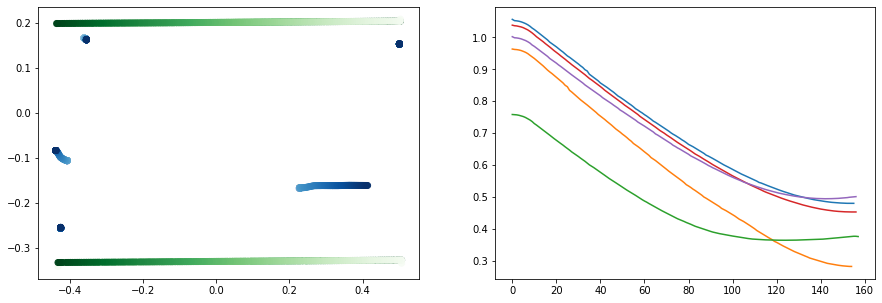

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for trial_idx, a in parameter_traces.iterrows():
    row = pd.DataFrame(a).T
    row = row.apply(pd.Series.explode)

    ax[0].scatter(row['mouse_x'], row['mouse_y'], c=row['time_vector'], cmap='Blues')
    ax[0].scatter(row['target_x'], row['target_y'], c=row['time_vector'], cmap='Greens')
    ax[1].plot(range(len(row)), row['target_mouse_distance_recalc'])

In [21]:
from matplotlib.gridspec import GridSpec
import ipywidgets as widgets

def plot_approach_params(data, idx=0):
    df = data[idx][0]
    trace = data[idx][1]
    features = data[idx][2]

    fig = plt.figure(figsize=(15,8))
    gs = GridSpec(8, 6, figure=fig)

    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.plot(df['time_vector'], df['target_mouse_distance_recalc']*100)
    ax1.axhline(dist_thresh*100, color='r')
    ax1.axvline(2, color='gray')
    ax1.set_ylabel('Mouse target dist \n (cm)')

    ax2 = fig.add_subplot(gs[2:4, :2])
    ax2.plot(df['time_vector'], df['mouse_speed']*100)
    ax2.axhline(speed_cutoff*100, color='r')
    ax2.set_ylabel('Mouse speed \n (cm/s)')

    ax3 = fig.add_subplot(gs[4:6, :2])
    ax3.plot(df['time_vector'], df['target_delta_heading'])
    # ax3.plot(np.diff(df[idx]['target_delta_heading']))
    ax3.set_ylim([-180, 180])
    ax3.set_ylabel('Target $\Delta$ heading \n (deg)')

    ax4 = fig.add_subplot(gs[6:, :2])
    ax4.plot(df['time_vector'], df['target_delta_head'])
    # ax4.plot(np.diff(df[idx]['target_delta_head']))
    ax4.set_ylim([-180, 180])
    ax4.set_ylabel('Target $\Delta$ head \n (deg)')
    ax4.set_xlabel('Time (s)')

    ax5 = fig.add_subplot(gs[2:6, 2:-1])
    ax5.scatter(trace['target_x'], trace['target_y'], marker='.', c='g', alpha=0.005)
    ax5.scatter(trace['mouse_x'], trace['mouse_y'], marker='.', c='b', alpha=0.01)
    p_tar = ax5.scatter(df['target_x'], df['target_y'], c=df['time_vector'], cmap='RdYlGn')
    p_mouse = ax5.scatter(df['mouse_x'], df['mouse_y'], c=df['time_vector'], cmap='RdYlBu')
    ax5.set_ylim([-0.35, 0.35])
    ax5.set_xlim([-0.65, 0.65])
    ax5.invert_xaxis()
    ax5.yaxis.tick_right()
    ax5.set_title("Color {}, Speed {} cm/s, Size {} cm \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]".format(*features, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

    ax6 = fig.add_subplot(gs[1:4, -1])  
    ax6.axis("off") 
    cba = plt.colorbar(p_tar, ax=ax6)
    cba.set_label('Target') 

    ax7 = fig.add_subplot(gs[4:-1, -1])    
    ax7.axis("off")
    cbb = plt.colorbar(p_mouse, ax=ax7)
    cbb.set_label('Mouse')

    plt.tight_layout()


In [14]:
ds_to_plot = all_valid_encs
widgets.interact(plot_approach_params, data=widgets.fixed(ds_to_plot), idx=(0, len(ds_to_plot) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=135), Output()), _dom_classes=('widget-interac…

<function __main__.plot_approach_params(data, idx=0)>

In [225]:
ds_to_plot = all_encounters
widgets.interact(plot_approach_params, data=widgets.fixed(ds_to_plot), idx=(0, len(ds_to_plot) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=347), Output()), _dom_classes=('widget-interac…

<function __main__.plot_approach_params(data, idx=0)>

In [12]:
def get_count_mean_sem(df: pd.DataFrame, grouping_params: list, target_param: str) -> pd.DataFrame:
    grouped = df.groupby(['date', 'experiment', *grouping_params])[target_param]
    count = grouped.sum().reset_index()
    mean = count.groupby([*grouping_params])[target_param].mean().unstack().T
    sem = count.groupby([*grouping_params])[target_param].sem().unstack().T

    return count, mean, sem

In [13]:
def get_percentage_trials(df: pd.DataFrame, grouping_params: list, target_param: str) -> pd.DataFrame:
    new_col_name = 'percent_{}'.format(target_param)

    grouped = df.groupby(['date', 'experiment', *grouping_params])[target_param]
    
    percent = 100 * grouped.sum() / grouped.count()
    percent = percent.reset_index()
    percent = percent.rename(columns={target_param: new_col_name})
    
    mean_percent = percent.groupby([*grouping_params])[new_col_name].mean().unstack().T
    sem_percent = percent.groupby([*grouping_params])[new_col_name].sem().unstack().T


    return percent, mean_percent, sem_percent

In [14]:
def percentage_approach_plot(mean: pd.DataFrame, sem: pd.DataFrame, all_trials: pd.DataFrame, grouping_params: list, target_param: str, fig=None):
    
    if fig is None:
        fig, ax = plt.subplots(figsize=(10,8))

    bar_width = 0.35
    labels = ['black', 'gray']

    counts = trial_encounters.groupby(grouping_params)[target_param].sum().unstack().T
    total = trial_encounters.groupby(grouping_params)[target_param].count().unstack().T

    for i, col in enumerate(mean.columns):
            x_labels = [int(label) for label in mean.index.to_list()]
            x = np.arange(len(x_labels))

            means = mean[col].to_list()
            sems = sem[col].to_list()
            count = counts[col].to_list()
            tot = total[col].to_list()

            rects = ax.bar(x + i*bar_width, means, bar_width, label=labels[i], color=col, edgecolor=(1, 1, 1), yerr=sems, ecolor=(0.5, 0.5, 0.5))
            
            for j, rect in enumerate(rects):
                height = rect.get_height()
                ax.annotate('{}/{}'.format(count[j], tot[j]),
                                xy=(rect.get_x() + rect.get_width() / 2, height + sems[j]),
                                xytext=(0, 15),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom')

    ax.set_xlabel(target_param)
    ax.set_ylabel('% Trials with Approach')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylim([0, 100])
    ax.legend()

    return fig

In [15]:
def count_approach_plot(all_trials: pd.DataFrame, mean: pd.DataFrame, sem: pd.DataFrame, fig=None):
    
    if fig is None:
        fig = plt.figure(figsize=(10,8))

    for col in mean.columns:
        x_labels = mean.index.to_list()

        means = mean[col].to_list()
        sems = sem[col].to_list()

        plt.errorbar(x_labels, means, yerr=sems, c=str(col[0]*3), linewidth=5, elinewidth=3)

    plt.ylabel('no. approaches')

    return fig

In [16]:
def rand_jitter(arr):
    stdev = .005 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev  

def plot_scatter_points(data: pd.DataFrame, target_param:str, value:str, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10,8))

    plt.scatter(rand_jitter(data[target_param]), rand_jitter(data[value]), s=60, c=[(t[0]*3, t[1]*3, t[2]*3, 1) for t in data['target_color']], linewidths=1, edgecolors='k')

    return fig

NameError: name 'dist_thresh' is not defined

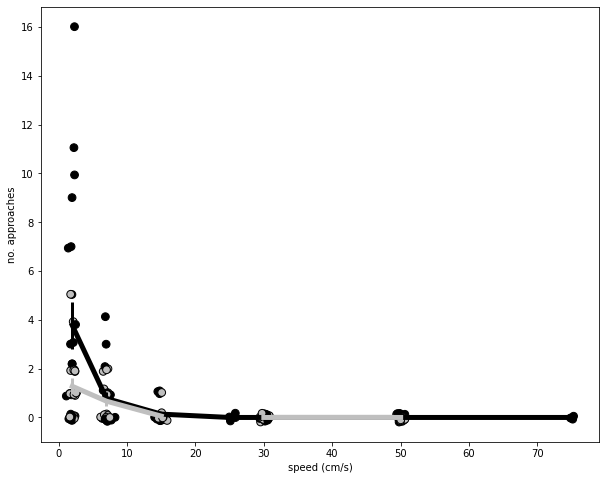

In [27]:
%matplotlib inline
speed_group, speed_mean, speed_sem = get_count_mean_sem(trial_encounters, ['target_color', 'speed'], 'encounters')

fig = plot_scatter_points(speed_group, 'speed', 'encounters')
fig = count_approach_plot(trial_encounters, speed_mean, speed_sem, fig=fig)
plt.xlabel('speed (cm/s)')
plt.title('Mean approaches by speed, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'speed_encounters', str(int(dist_thresh*100)), str(int(speed_cutoff*100)), str(int(start_distance_cutoff*100))]))
plt.savefig(save_path)

NameError: name 'dist_thresh' is not defined

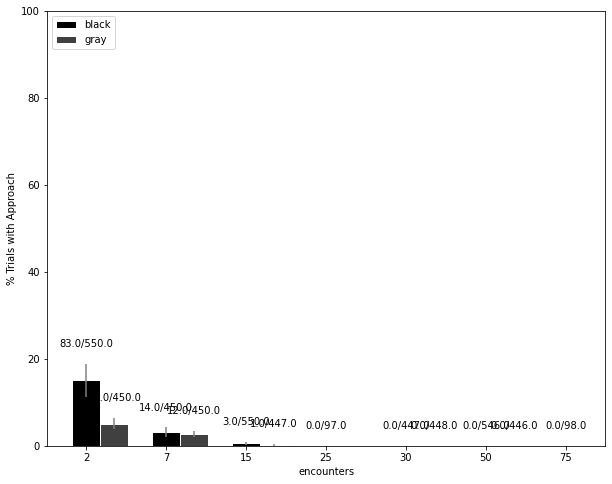

In [28]:
percent_speed_approach, percent_speed_mean, percent_speed_sem = get_percentage_trials(trial_encounters, ['target_color', 'speed'], 'encounters')

fig = percentage_approach_plot(percent_speed_mean, percent_speed_sem, trial_encounters, ['target_color', 'speed'], 'encounters')
plt.title('Percent of trials with approach by speed, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))
plt.xlabel('speed (cm/s)')

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'speed_percent_engagement', str(int(dist_thresh*100)), str(int(speed_cutoff*100)), str(int(start_distance_cutoff*100))]))
plt.savefig(save_path)

NameError: name 'dist_thresh' is not defined

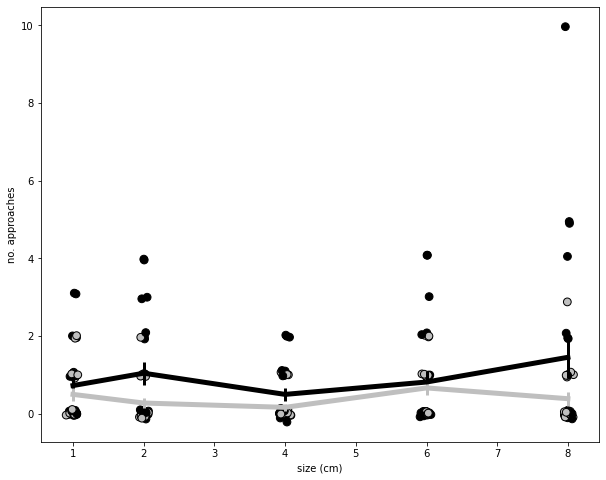

In [29]:
scale_group, scale_mean, scale_sem = get_count_mean_sem(trial_encounters, ['target_color', 'scale'], 'encounters')

fig = plot_scatter_points(scale_group, 'scale', 'encounters')
fig = count_approach_plot(trial_encounters, scale_mean, scale_sem, fig=fig)
plt.xlabel('size (cm)')
plt.title('Mean approaches by scale, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'scale_encounters', str(int(dist_thresh*100)), str(int(speed_cutoff*100)), str(int(start_distance_cutoff*100))]))
plt.savefig(save_path)

NameError: name 'dist_thresh' is not defined

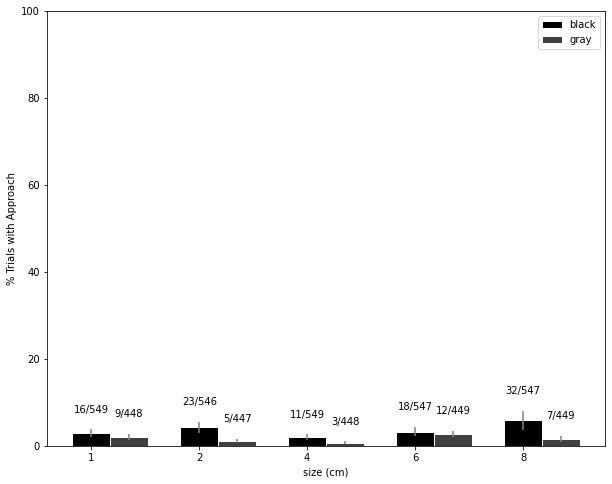

In [30]:
percent_scale_approach, percent_scale_mean, percent_scale_sem = get_percentage_trials(trial_encounters, ['target_color', 'scale'], 'encounters')

percentage_approach_plot(percent_scale_mean, percent_scale_sem, trial_encounters, ['target_color', 'scale'], 'encounters')
plt.xlabel('size (cm)')
plt.title('Percent of trials with approach by scale, {} target \n [final mouse-target dist: {} cm, mean speed: {} cm/s, start distance: {} cm]'.format(dimensionality, int(dist_thresh*100), int(speed_cutoff*100), int(start_distance_cutoff*100)))

save_path = os.path.join(paths.figures_path, '_'.join([save_name, 'scale_percent_engagement', str(int(dist_thresh*100)), str(int(speed_cutoff*100))]))
plt.savefig(save_path)

In [17]:
from matplotlib import ticker

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) < threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_heatmap(values, xlabels, ylabels, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    im = ax.imshow(values, cmap='viridis')
    texts = annotate_heatmap(im, valfmt="{x:.1f}")


    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels)
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels)
    ax.invert_yaxis()

    return im, ax

In [106]:
def plot_approach_heatmaps_by_contrast(df, cbar_label, level=0):
    colors = df.groupby(level=[level]).agg(list).index.to_list()
    color_labels = {'(0, 0, 0, 1)': 'black',
                    '(0.25, 0.25, 0.25, 1)': 'gray',
    }

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    for i, color in enumerate(colors):
        data = df.xs(color, level=level)
        values = data.values
        speeds = [int(a) for a in data.index.to_list()]
        scales = data.columns.to_list()
        
        im, _ = plot_heatmap(values, scales, speeds, ax=axes[i])
        fig.colorbar(im, ax=axes[i], label=cbar_label)
        
        axes[i].set_ylabel('Speeds [cm/s]')
        axes[i].set_xlabel("Scale [cm]")
        axes[i].set_title('Color: {}'.format(color_labels[str(color)]))

    return fig, axes

In [107]:
percent_approach, percent_mean, percent_sem = get_percentage_trials(trial_encounters, ['target_color', 'speed', 'scale'], 'has_encounter')
num_approach, num_mean, num_sem = get_count_mean_sem(trial_encounters, ['target_color', 'speed', 'scale'], 'has_encounter')

Text(0.5, 0.98, 'Fraction of trials with encounter')

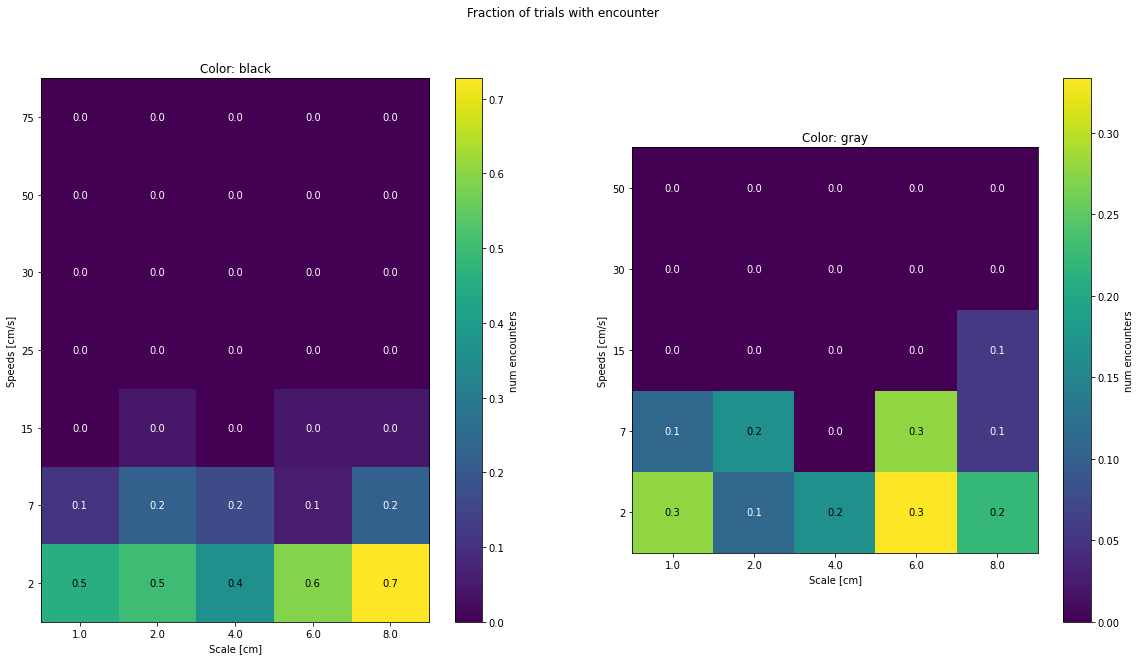

In [108]:
%matplotlib inline
fig, ax = plot_approach_heatmaps_by_contrast(num_mean.T, 'num encounters')
plt.suptitle('Fraction of trials with encounter')

In [73]:
a = trial_encounters.groupby(['date', 'target_color', 'speed', 'scale'])['has_encounter'].sum() / trial_encounters.groupby(['date', 'target_color', 'speed', 'scale'])['has_encounter'].count()

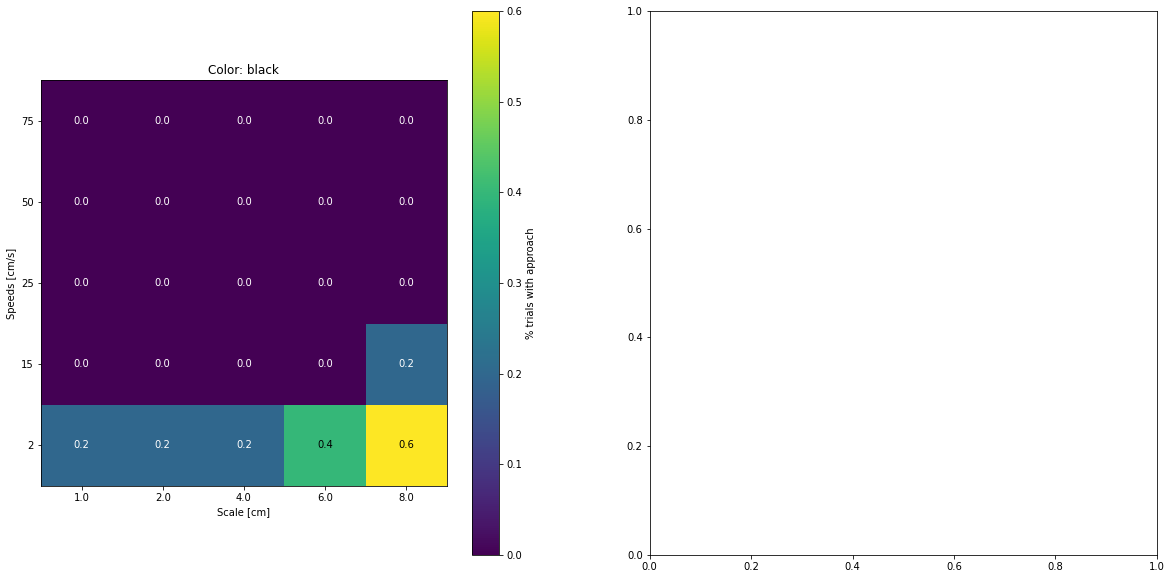

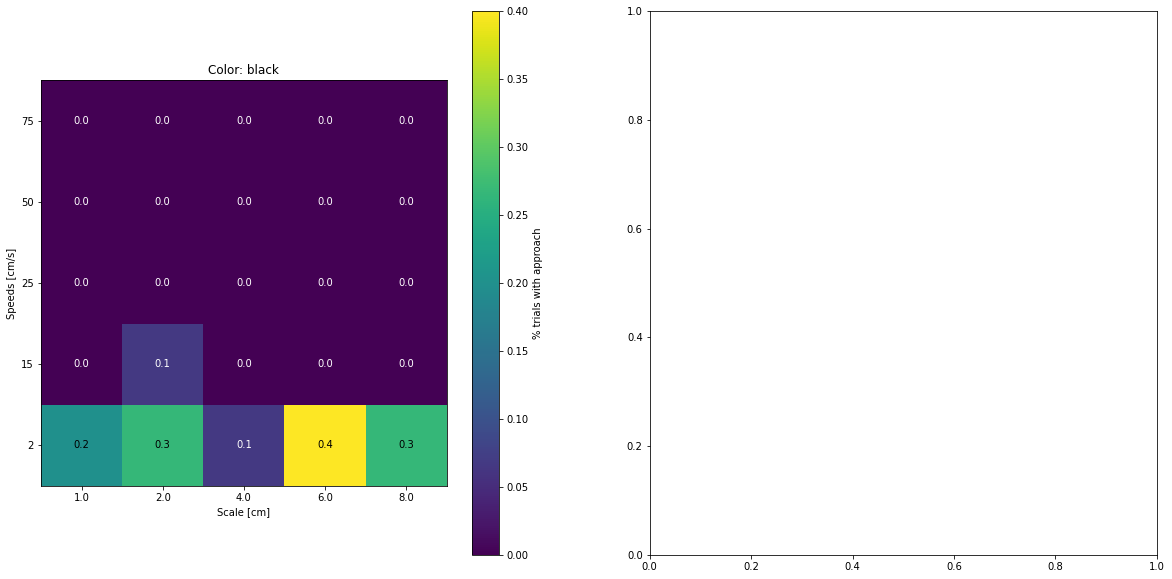

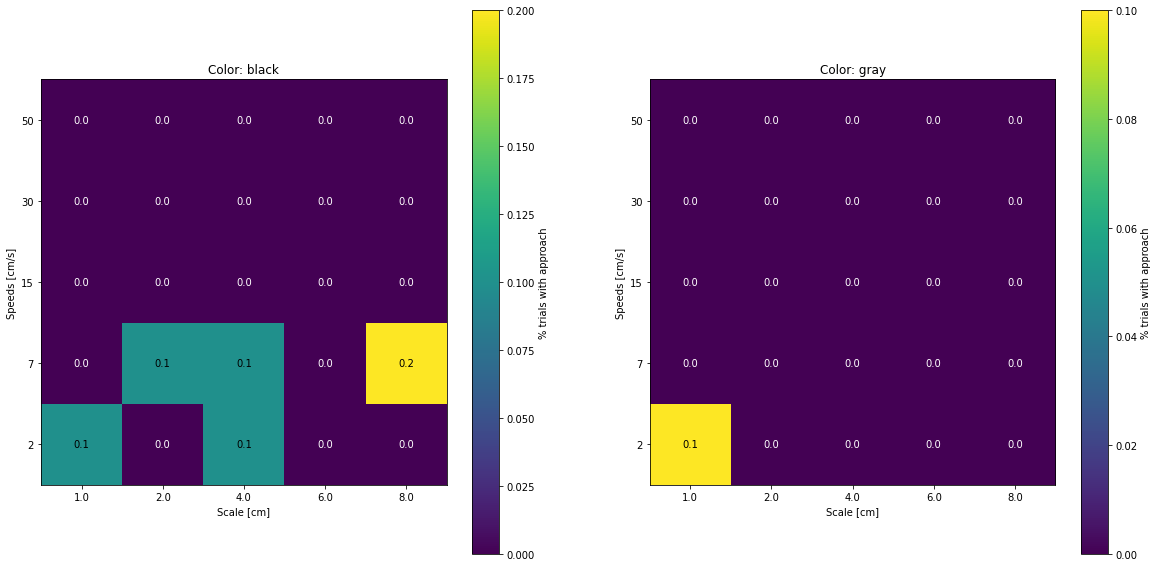

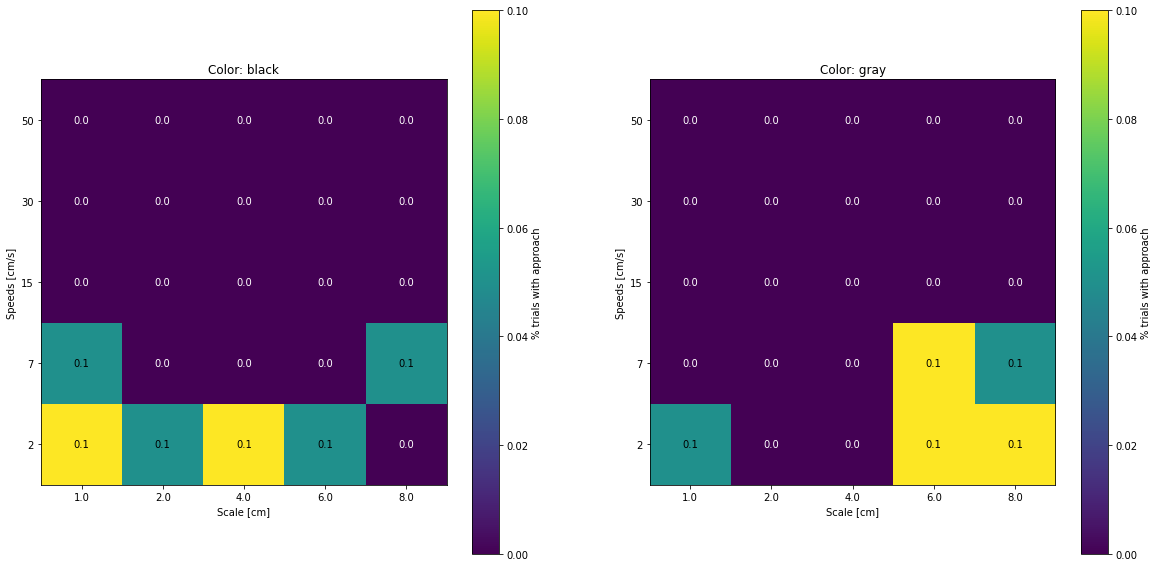

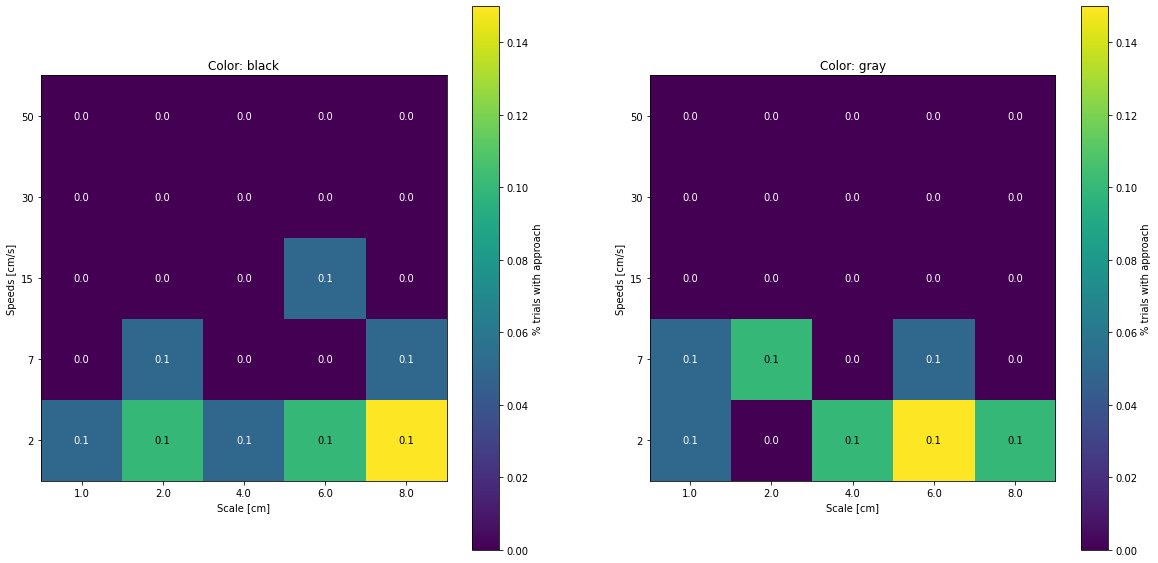

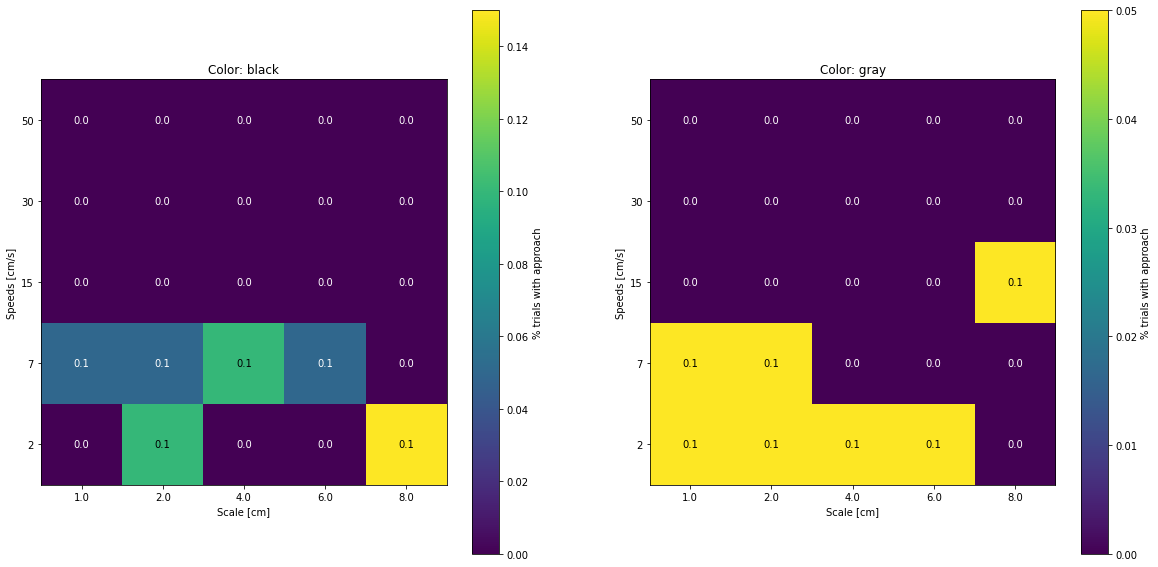

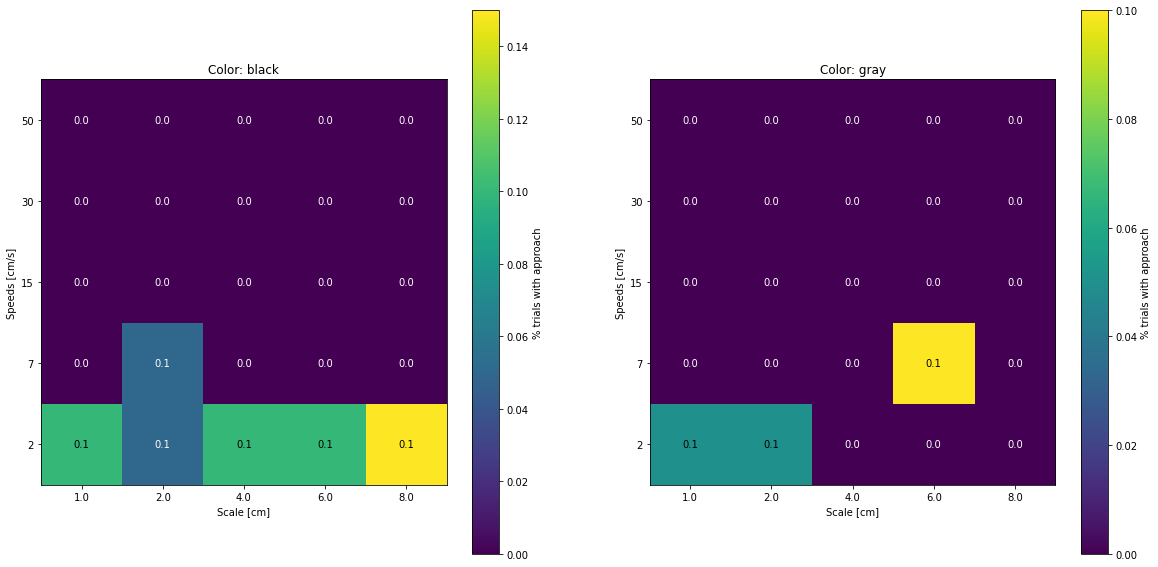

In [110]:
rows = len(list(a.groupby(['date']).groups.keys()))
cols = len(list(a.groupby(['target_color']).groups.keys()))

# fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))

row = 0
col = 0
for date, d in a.unstack().groupby(['date']):
    d = d.reset_index(level=0, drop=True)
    plot_approach_heatmaps_by_contrast(d, '% trials with approach')
        